# Generazione Cluster per Raccomandazione Videogiochi

**Pipeline**: Aggressive Dimensionality Reduction
- Feature: Solo `genres` (no tags)
- TF-IDF (max_features=1000)
- TruncatedSVD (n_components=5)
- StandardScaler
- K-Means (n_clusters=30)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

## 1. Caricamento Dati

In [2]:
df = pd.read_csv('datasets/steam-games-cleaned.csv')
print(f"Dataset: {len(df):,} giochi")

df['genres'] = df['genres'].fillna('')
print(df['genres'].head(10))

Dataset: 42,410 giochi
0                                  Action Free_to_Play
1                         Action Strategy Free_to_Play
2                                     Action Adventure
3                                           Action RPG
4                        Action Adventure Free_to_Play
5                                                  RPG
6                               Adventure RPG Strategy
7    Action Adventure Massively_Multiplayer Free_to...
8                        Action Adventure Free_to_Play
9                                      Action Strategy
Name: genres, dtype: str


## 2. TF-IDF

In [3]:
tfidf = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf.fit_transform(df['genres'])
print(f"TF-IDF: {tfidf_matrix.shape}")

TF-IDF: (42410, 24)


## 3. TruncatedSVD (n_components=5)

In [4]:
svd = TruncatedSVD(n_components=5, random_state=42)
svd_matrix = svd.fit_transform(tfidf_matrix)
print(f"SVD: {svd_matrix.shape}, Varianza: {svd.explained_variance_ratio_.sum():.2%}")

SVD: (42410, 5), Varianza: 61.61%


## 4. StandardScaler

In [5]:
scaler = StandardScaler()
scaled_matrix = scaler.fit_transform(svd_matrix)
print(f"Scaled: {scaled_matrix.shape}")

Scaled: (42410, 5)


## 5. K-Means Clustering

In [ ]:
N_CLUSTERS = 40

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(scaled_matrix)

sil_score = silhouette_score(scaled_matrix, df['cluster'])

print("=" * 50)
print(f"SILHOUETTE SCORE: {sil_score:.4f}")
print("=" * 50)

if sil_score > 0.50:
    print("✓ Obiettivo raggiunto (> 0.50)")

SILHOUETTE SCORE: 0.5683
✓ Obiettivo raggiunto (> 0.50)


## 6. Distribuzione Cluster

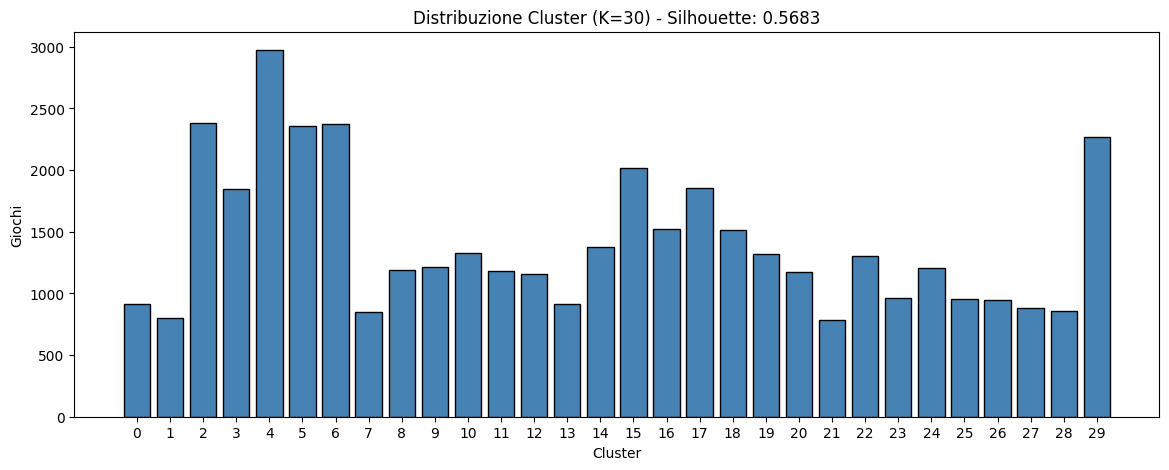

Min: 783, Max: 2,974, Media: 1,414


In [7]:
cluster_dist = df['cluster'].value_counts().sort_index()

plt.figure(figsize=(14, 5))
plt.bar(cluster_dist.index, cluster_dist.values, color='steelblue', edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Giochi')
plt.title(f'Distribuzione Cluster (K={N_CLUSTERS}) - Silhouette: {sil_score:.4f}')
plt.xticks(cluster_dist.index)
plt.show()

print(f"Min: {cluster_dist.min():,}, Max: {cluster_dist.max():,}, Media: {cluster_dist.mean():,.0f}")

## 7. Visualizzazione t-SNE

Calcolo t-SNE...


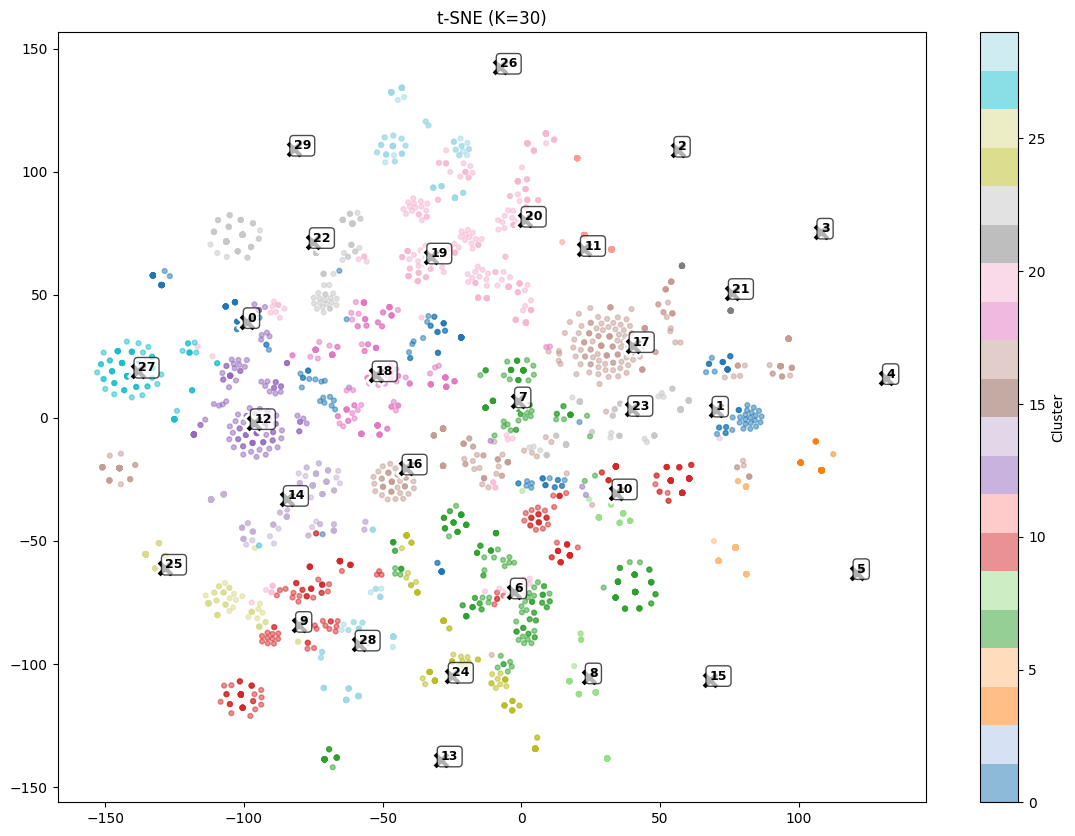

In [8]:
print("Calcolo t-SNE...")
idx = np.random.choice(len(scaled_matrix), min(5000, len(scaled_matrix)), replace=False)
pts = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(scaled_matrix[idx])
cluster_labels = df['cluster'].iloc[idx].values

# Calcola centroidi come MEDIANA delle coordinate t-SNE per ogni cluster (più robusto per le forme strane)
ctrs = np.zeros((N_CLUSTERS, 2))
for i in range(N_CLUSTERS):
    mask = cluster_labels == i
    if mask.sum() > 0:
        ctrs[i] = np.median(pts[mask], axis=0)

plt.figure(figsize=(14, 10))
scatter = plt.scatter(pts[:, 0], pts[:, 1], c=cluster_labels, cmap='tab20', alpha=0.5, s=12)
plt.scatter(ctrs[:, 0], ctrs[:, 1], c='black', marker='X', s=200, edgecolor='white', linewidth=2)

for i, (x, y) in enumerate(ctrs):
    plt.annotate(str(i), (x, y), fontsize=9, fontweight='bold',
                 bbox=dict(boxstyle='round', fc='white', alpha=0.7))

plt.colorbar(scatter, label='Cluster')
plt.title(f't-SNE (K={N_CLUSTERS})')
plt.show()

## 8. Salvataggio Modello

In [9]:
model = {
    'dataframe': df,
    'matrix': scaled_matrix,
    'clustering_model': kmeans,
    'tfidf_vectorizer': tfidf,
    'svd': svd,
    'scaler': scaler,
    'optimal_k': N_CLUSTERS,
    'silhouette_score': sil_score,
    'algorithm': f'TF-IDF (genres) + SVD(5) + K-Means'
}

with open('models/high_precision_clustering.pkl', 'wb') as f:
    pickle.dump(model, f)

print(f"Salvato! K={N_CLUSTERS}, Silhouette={sil_score:.4f}")

Salvato! K=30, Silhouette=0.5683
